In [1]:
%who

Interactive namespace is empty.


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 4) #threads_per_worker = 1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37329,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://10.0.128.141:34683,Total threads: 2
Dashboard: /proxy/34919/status,Memory: 5.62 GiB
Nanny: tcp://127.0.0.1:44441,


In [1]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=4,memory="15GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=4)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.138:43021,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
%who

Client	 SLURMCluster	 Scheduler	 client	 cluster	 


In [5]:
! squeue -u ad9701

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             17742       vdi sys/dash   ad9701  R    3:58:47      1 ood-vn10


In [3]:
%%time

# import sys
# new_path = '/home/566/ad9701/drought_probability/'
# if new_path not in sys.path:
#     sys.path.append(new_path)

import xarray as xr
import numpy as np
import pandas as pd
#import my_glmfit_funcs as my
import climtas.io
import statsmodels.formula.api as smf
import statsmodels.api as sm

# define a function to fit a one predictor linear regression model
def fit_lm_1Pred(y, x, dryInd, predictand, predictor):
    if sum(dryInd) < 4:
        lm_params = np.array([np.nan])
        lm_pvalues = np.array([np.nan])
        lm_rsq_adj = np.nan
    else:
        xy_dict = {predictand:y[dryInd], predictor:x[dryInd]}
        xy_df = pd.DataFrame(xy_dict)
        # model_lm = sm.OLS(y, x).fit()
        formula = predictand + ' ~ ' + predictor# + ' -1'  # Include -1 if there is to be no intercept
        lm = smf.ols(formula, xy_df)
        model_lm = lm.fit()
        lm_params = model_lm.params.values
        lm_pvalues = model_lm.pvalues.values
        lm_rsq_adj = model_lm.rsquared_adj
    return lm_params, lm_pvalues, lm_rsq_adj

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

timescale = [2] #[6, 12] #,2, 12] 

fname_sm_init = 'sm_init_*_SEA_*.nc'
fname_sm_diff = 'sm_diff_*_SEA_*.nc'
fname_PmEQ = 'PminusEQ_*_SEA_*.nc'

sm_thresh_perc = 0.3 #0.5 #0.3     # this is the thershold percentile to identify dry soil moisture conditions - do I really need to do this? 
ds_sm_perc = xr.open_dataset(projdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
da_sm_thresh = ds_sm_perc['sm'].sel(quantile = sm_thresh_perc)
# day of year is not properly assigned in the dataset of percentiles; reassigning
dayofyear = np.arange(366) + 1
da_sm_thresh = da_sm_thresh.assign_coords(dayofyear = dayofyear)

for ts in timescale:
    print('Working on timescale ' + str(ts))
    
    # read data
    data_dir_PmEQ = projdir + 'PminusEQ_week'+str(ts)+'/'
    ds_PmEQ = xr.open_mfdataset(data_dir_PmEQ + fname_PmEQ, chunks = {'lat':200, 'lon':100}) 
    
    data_dir_sm = projdir + 'sm_week'+str(ts)+'/'
    ds_sm_init = xr.open_mfdataset(data_dir_sm + fname_sm_init, chunks = {'lat':200, 'lon':100})
    ds_sm_diff = xr.open_mfdataset(data_dir_sm + fname_sm_diff, chunks = {'lat':200, 'lon':100})
    
    # get the corresponding thershold for each day in the init sm dataset
    da_sm_init_thresh = da_sm_thresh.sel(dayofyear = ds_sm_init['time.dayofyear'])
    
    da_PmEQ = ds_PmEQ['PminusEQ'].assign_coords(time = ds_sm_init.time).reindex(lat=ds_PmEQ.lat[::-1]).chunk(chunks = {'time':-1})   # reassigning the time & lat dimension of PmEQ to match sm exactly
    da_sm_init = ds_sm_init['sm'].chunk(chunks = {'time':-1})                                                                        # time should not be chunked becasue its the core dimension of input into ufunc
    da_sm_diff = ds_sm_diff['sm_diff'].chunk(chunks = {'time':-1})
    
    # 1. Index of dry initial soil mositure days & positive changes in delta soil moisture
    # da_dryInd = ((da_sm_init<=da_sm_init_thresh) & (da_sm_diff>0)).reset_coords(['quantile','dayofyear'], drop=True)
    # 2. Index of dry intial sm days irrespective whether the changes are +ve or -ve
    # da_dryInd = (da_sm_init<=da_sm_init_thresh).reset_coords(['quantile','dayofyear'], drop=True)
    # 3. Fitting different regressions for wetting and drying processes
    da_dryInd_pos = ((da_sm_init<=da_sm_init_thresh) & (da_sm_diff>=0)).reset_coords(['quantile','dayofyear'], drop=True)
    da_dryInd_neg = ((da_sm_init<=da_sm_init_thresh) & (da_sm_diff<=0)).reset_coords(['quantile','dayofyear'], drop=True)
    
    # apply the ufunc to fit logistic regression
    dask_gufunc_kwargs = {'output_sizes':{"parameter": 2}}
    kwargs = {'predictand': 'delSM', 'predictor':'PmEQ'}
    
    ###############
    # pos changes
    ###############
    da_lmReg = xr.apply_ufunc(
        fit_lm_1Pred,                      # first the function, this function returns a tuple (params, pvalues, adjusted rsquared)
        da_sm_diff,                           # function arg
        da_PmEQ,                              #      "
        da_dryInd_pos,                            # function arg
        kwargs = kwargs,                      #      "
        input_core_dims=[["time"], ["time"], ["time"]],   # list with one entry per arg, these are the dimensions not to be broadcast
        output_core_dims=[["parameter"], ["parameter"], []],      # dimensions of the output
        vectorize=True,                                           # broadcast over non-core dimensions of the input object?
        dask="parallelized",                                      # enable dask?
        dask_gufunc_kwargs=dask_gufunc_kwargs,                     
        output_dtypes=[float, float, float]
    )
    
    # assign co-ordinates add metadata and store in a dataset
    new_coords_dict = {'parameter':['Intercept', 'PmEQ']}
    ds_all = da_lmReg[0].rename('lm_params').assign_coords(new_coords_dict).to_dataset()
    ds_all['lm_pvalues'] = da_lmReg[1].assign_coords(new_coords_dict)
    ds_all['r-squared'] = da_lmReg[2]

    # save file
    out_file = data_dir_sm + 'sm_PmEQ_lm_results_wNegChanges_threshpt3_pos.nc'
    ds_all.to_netcdf(out_file)
    # climtas.io.to_netcdf_throttled(ds_all, out_file)
    del ds_all, da_lmReg
    
    ###############
    # neg changes
    ###############  
    da_lmReg = xr.apply_ufunc(
        fit_lm_1Pred,                      # first the function, this function returns a tuple (params, pvalues, adjusted rsquared)
        da_sm_diff,                           # function arg
        da_PmEQ,                              #      "
        da_dryInd_neg,                            # function arg
        kwargs = kwargs,                      #      "
        input_core_dims=[["time"], ["time"], ["time"]],   # list with one entry per arg, these are the dimensions not to be broadcast
        output_core_dims=[["parameter"], ["parameter"], []],      # dimensions of the output
        vectorize=True,                                           # broadcast over non-core dimensions of the input object?
        dask="parallelized",                                      # enable dask?
        dask_gufunc_kwargs=dask_gufunc_kwargs,                     
        output_dtypes=[float, float, float]
    )
    
    # assign co-ordinates add metadata and store in a dataset
    new_coords_dict = {'parameter':['Intercept', 'PmEQ']}
    ds_all = da_lmReg[0].rename('lm_params').assign_coords(new_coords_dict).to_dataset()
    ds_all['lm_pvalues'] = da_lmReg[1].assign_coords(new_coords_dict)
    ds_all['r-squared'] = da_lmReg[2]

    # save file
    out_file = data_dir_sm + 'sm_PmEQ_lm_results_wNegChanges_threshpt3_neg.nc'
    ds_all.to_netcdf(out_file)
    # climtas.io.to_netcdf_throttled(ds_all, out_file)
    del ds_all, da_lmReg, da_sm_diff, da_sm_init, da_dryInd_pos, da_dryInd_neg, da_sm_init_thresh, ds_sm_diff, ds_sm_init, ds_PmEQ
    
cluster.scale(cores=0)

Working on timescale 2


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 53.7 s, sys: 13.3 s, total: 1min 6s
Wall time: 10min 35s


In [16]:
cluster.scale(cores=0)

In [2]:
da_sm_init

<xarray.DataArray 'sm' (time: 2854, lat: 141, lon: 261)>
dask.array<rechunk-merge, shape=(2854, 141, 261), dtype=float32, chunksize=(2854, 141, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1911-01-01 1911-01-15 ... 2020-05-10
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
Attributes:
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm
    name:           sm
    units:          mm

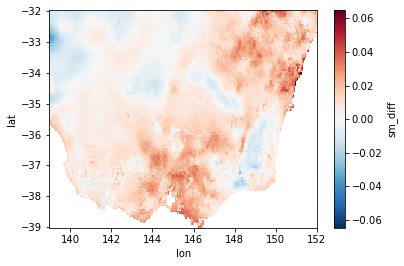

In [8]:
da_sm_diff.mean('time').plot()

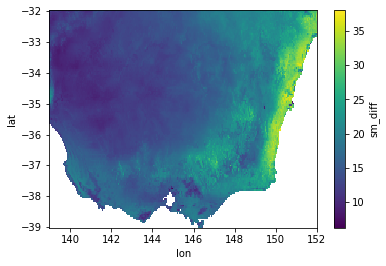

In [9]:
da_sm_diff.where(da_sm_diff>0).mean('time').plot()

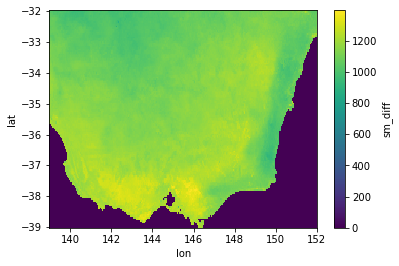

In [ ]:
da_sm_diff.where(da_sm_diff>0).count('time').plot()

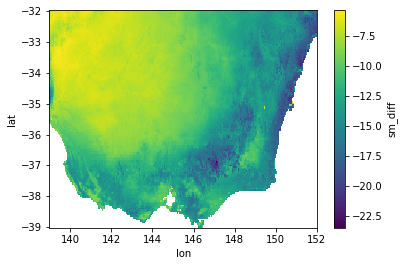

In [10]:
da_sm_diff.where(da_sm_diff<0).mean('time').plot()

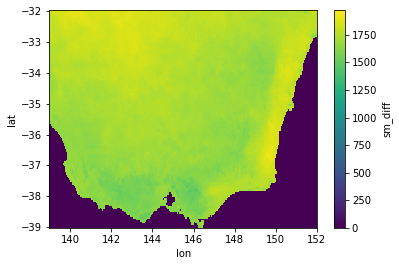

In [ ]:
da_sm_diff.where(da_sm_diff<0).count('time').plot()

In [ ]:
# apply the ufunc to fit logistic regression
dask_gufunc_kwargs = {'output_sizes':{"parameter": 2}}
kwargs = {'predictand': 'delSM', 'predictor':'PmEQ'}
da_lmReg = xr.apply_ufunc(
    fit_lm_1Pred,                      # first the function, this function returns a tuple (params, pvalues, adjusted rsquared)
    da_sm_diff,                           # function arg
    da_PmEQ,                              #      "
    da_dryInd,                            # function arg
    kwargs = kwargs,                      #      "
    input_core_dims=[["time"], ["time"], ["time"]],   # list with one entry per arg, these are the dimensions not to be broadcast
    output_core_dims=[["parameter"], ["parameter"], []],      # dimensions of the output
    vectorize=True,                                           # broadcast over non-core dimensions of the input object?
    dask="parallelized",                                      # enable dask?
    dask_gufunc_kwargs=dask_gufunc_kwargs,                     
    output_dtypes=[float, float, float]
)

### Fitting relationship by season

In [1]:
%%time

# import sys
# new_path = '/home/566/ad9701/drought_probability/'
# if new_path not in sys.path:
#     sys.path.append(new_path)

import xarray as xr
import numpy as np
import pandas as pd
#import my_glmfit_funcs as my
import climtas.io
import statsmodels.formula.api as smf
import statsmodels.api as sm

# define a function to fit a one predictor linear regression model
def fit_lm_1Pred(y, x, dryInd, predictand, predictor):
    if sum(dryInd) < 4:
        lm_params = np.array([np.nan])
        lm_pvalues = np.array([np.nan])
        lm_rsq_adj = np.nan
    else:
        xy_dict = {predictand:y[dryInd], predictor:x[dryInd]}
        xy_df = pd.DataFrame(xy_dict)
        # model_lm = sm.OLS(y, x).fit()
        formula = predictand + ' ~ ' + predictor# + ' -1'  # Include -1 if there is to be no intercept
        lm = smf.ols(formula, xy_df)
        model_lm = lm.fit()
        lm_params = model_lm.params.values
        lm_pvalues = model_lm.pvalues.values
        lm_rsq_adj = model_lm.rsquared_adj
    return lm_params, lm_pvalues, lm_rsq_adj

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

timescale = [2, 6, 12] #,2, 12] 

fname_sm_init = 'sm_init_*_SEA_*.nc'
fname_sm_diff = 'sm_diff_*_SEA_*.nc'
fname_PmEQ = 'PminusEQ_*_SEA_*.nc'

sm_thresh_perc = 0.3     # this is the thershold percentile to identify dry soil moisture conditions - do I really need to do this? 
ds_sm_perc = xr.open_dataset(projdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
da_sm_thresh = ds_sm_perc['sm'].sel(quantile = sm_thresh_perc)
# day of year is not properly assigned in the dataset of percentiles; reassigning
dayofyear = np.arange(366) + 1
da_sm_thresh = da_sm_thresh.assign_coords(dayofyear = dayofyear)

for ts in timescale:
    print('Working on timescale ' + str(ts))
    
    # read data
    data_dir_PmEQ = projdir + 'PminusEQ_week'+str(ts)+'/'
    ds_PmEQ = xr.open_mfdataset(data_dir_PmEQ + fname_PmEQ, chunks = {'lat':200, 'lon':100}) 
    
    data_dir_sm = projdir + 'sm_week'+str(ts)+'/'
    ds_sm_init = xr.open_mfdataset(data_dir_sm + fname_sm_init, chunks = {'lat':200, 'lon':100})
    ds_sm_diff = xr.open_mfdataset(data_dir_sm + fname_sm_diff, chunks = {'lat':200, 'lon':100})
    
    # get the corresponding thershold for each day in the init sm dataset
    da_sm_init_thresh = da_sm_thresh.sel(dayofyear = ds_sm_init['time.dayofyear'])
    
    da_PmEQ = ds_PmEQ['PminusEQ'].assign_coords(time = ds_sm_init.time).reindex(lat=ds_PmEQ.lat[::-1]).chunk(chunks = {'time':-1})   # reassigning the time & lat dimension of PmEQ to match sm exactly
    da_sm_init = ds_sm_init['sm'].chunk(chunks = {'time':-1})                                                                        # time should not be chunked becasue its the core dimension of input into ufunc
    da_sm_diff = ds_sm_diff['sm_diff'].chunk(chunks = {'time':-1})
    
    # 1. Index of dry initial soil mositure days & positive changes in delta soil moisture
    # da_dryInd = ((da_sm_init<=da_sm_init_thresh) & (da_sm_diff>0)).reset_coords(['quantile','dayofyear'], drop=True)
    # 2. Index of dry intial sm days irrespective whether the changes are +ve or -ve
    da_dryInd = (da_sm_init<=da_sm_init_thresh).reset_coords(['quantile','dayofyear'], drop=True)
    
    # apply the ufunc to fit logistic regression
    dask_gufunc_kwargs = {'output_sizes':{"parameter": 2}}
    kwargs = {'predictand': 'delSM', 'predictor':'PmEQ'}
    da_lmReg = xr.apply_ufunc(
        fit_lm_1Pred,                      # first the function, this function returns a tuple (params, pvalues, adjusted rsquared)
        da_sm_diff.groupby('time.season'),                           # function arg
        da_PmEQ.groupby('time.season'),                              #      "
        da_dryInd.groupby('time.season'),                            # function arg
        kwargs = kwargs,                      #      "
        input_core_dims=[["time"], ["time"], ["time"]],   # list with one entry per arg, these are the dimensions not to be broadcast
        output_core_dims=[["parameter"], ["parameter"], []],      # dimensions of the output
        vectorize=True,                                           # broadcast over non-core dimensions of the input object?
        dask="parallelized",                                      # enable dask?
        dask_gufunc_kwargs=dask_gufunc_kwargs,                     
        output_dtypes=[float, float, float]
    )
    
    # assign co-ordinates add metadata and store in a dataset
    new_coords_dict = {'parameter':['Intercept', 'PmEQ']}
    ds_all = da_lmReg[0].rename('lm_params').assign_coords(new_coords_dict).to_dataset()
    ds_all['lm_pvalues'] = da_lmReg[1].assign_coords(new_coords_dict)
    ds_all['r-squared'] = da_lmReg[2]

    # save file
    out_file = data_dir_sm + 'sm_PmEQ_lm_results_wNegChanges_bySeas.nc'
    ds_all.to_netcdf(out_file)
    # climtas.io.to_netcdf_throttled(ds_all, out_file)
    del ds_all, da_lmReg, da_sm_diff, da_sm_init, da_dryInd, da_sm_init_thresh, ds_sm_diff, ds_sm_init, ds_PmEQ

Working on timescale 2


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Working on timescale 6
Working on timescale 12
CPU times: user 1h 22min 36s, sys: 7min 39s, total: 1h 30min 15s
Wall time: 1h 28min 21s


In [11]:
da_lmReg[2]

<xarray.DataArray (season: 4, lat: 141, lon: 261)>
dask.array<concatenate, shape=(4, 141, 261), dtype=float64, chunksize=(1, 141, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [6]:
da_PmEQ.groupby('time.season')['DJF']

<xarray.DataArray 'PminusEQ' (time: 117, lat: 141, lon: 261)>
dask.array<getitem, shape=(117, 141, 261), dtype=float64, chunksize=(117, 141, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * time     (time) datetime64[ns] 1911-01-01 1911-12-03 ... 2020-01-05
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0

In [7]:
da_dryInd

<xarray.DataArray 'sm' (time: 475, lat: 141, lon: 261)>
dask.array<le, shape=(475, 141, 261), dtype=bool, chunksize=(475, 141, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1911-01-01 1911-03-26 ... 2020-01-05
  * lat      (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon      (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0

In [7]:
climtas.io.to_netcdf_throttled(ds_all, out_file)

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
ds_all

<xarray.Dataset>
Dimensions:     (lat: 141, lon: 261, parameter: 1)
Coordinates:
  * lat         (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon         (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 152.0
  * parameter   (parameter) <U4 'PmEQ'
Data variables:
    lm_params   (lat, lon, parameter) float64 dask.array<chunksize=(141, 100, 1), meta=np.ndarray>
    lm_pvalues  (lat, lon, parameter) float64 dask.array<chunksize=(141, 100, 1), meta=np.ndarray>
    r-squared   (lat, lon) float64 dask.array<chunksize=(141, 100), meta=np.ndarray>

In [6]:
cluster.scale(cores=0)

In [4]:
! squeue -u ad9701

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              8213       vdi sys/dash   ad9701  R    3:10:33      1 ood-vn2


In [5]:
ds_all['lm_params']

<xarray.DataArray 'lm_params' (lat: 141, lon: 261, parameter: 1)>
dask.array<transpose, shape=(141, 261, 1), dtype=float64, chunksize=(141, 100, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * parameter  (parameter) <U4 'PmEQ'

In [33]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40959,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: 23 minutes ago,Total memory: 11.23 GiB
Comm: tcp://10.0.128.153:46655,Total threads: 1
Dashboard: /proxy/42679/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:45601,


In [32]:
cluster.scale(cores = 4)

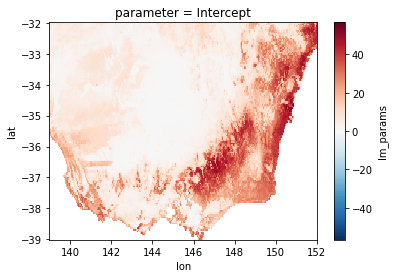

In [10]:
ds_out = xr.open_dataset(out_file)
ds_out['lm_params'][:,:,0].plot()

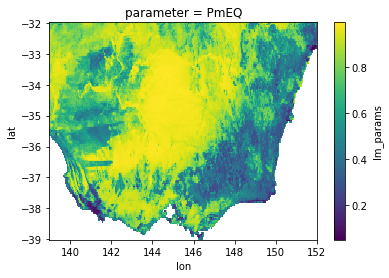

In [14]:
ds_out['lm_params'][:,:,1].plot()

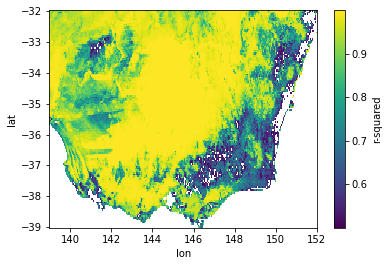

In [25]:
ds_out['r-squared'].where(ds_out['r-squared']>0.5).plot()

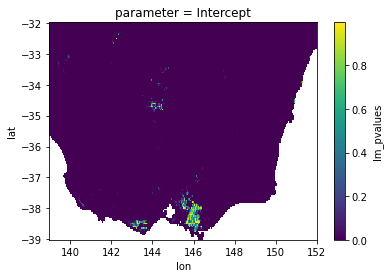

In [28]:
ds_out['lm_pvalues'][:,:,0].plot() #.where(ds_out['lm_pvalues'][:,:,1]<0.05).plot()

In [12]:
ds_all['lm_pvalues']

<xarray.DataArray 'lm_pvalues' (lat: 141, lon: 261, parameter: 2)>
dask.array<transpose, shape=(141, 261, 2), dtype=float64, chunksize=(141, 100, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * parameter  (parameter) <U9 'Intercept' 'PmEQ'

In [1]:
# import sys
# new_path = '/home/566/ad9701/drought_probability/'
# if new_path not in sys.path:
#     sys.path.append(new_path)

import xarray as xr
import numpy as np
import pandas as pd
#import my_glmfit_funcs as my
import climtas.io
import statsmodels.formula.api as smf

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

timescale = [12] #[6, 8] #,2, 12] 

fname_sm_init = 'sm_init_*_SEA_*.nc'
fname_sm_diff = 'sm_diff_*_SEA_*.nc'
fname_PmEQ = 'PminusEQ_*_SEA_*.nc'

sm_thresh_perc = 0.3     # this is the thershold percentile to identify dry soil moisture conditions
ds_sm_perc = xr.open_dataset(projdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
da_sm_thresh = ds_sm_perc['sm'].sel(quantile = sm_thresh_perc)
# day of year is not properly assigned in the dataset of percentiles; reassigning
dayofyear = np.arange(366) + 1
da_sm_thresh = da_sm_thresh.assign_coords(dayofyear = dayofyear)

for ts in timescale:
    
    # read data
    data_dir_PmEQ = projdir + 'PminusEQ_week'+str(ts)+'/'
    ds_PmEQ = xr.open_mfdataset(data_dir_PmEQ + fname_PmEQ, chunks = {'lat':200, 'lon':100}) 
    
    data_dir_sm = projdir + 'sm_week'+str(ts)+'/'
    ds_sm_init = xr.open_mfdataset(data_dir_sm + fname_sm_init, chunks = {'lat':200, 'lon':100})
    ds_sm_diff = xr.open_mfdataset(data_dir_sm + fname_sm_diff, chunks = {'lat':200, 'lon':100})
    
    # get the corresponding thershold for each day in the init sm dataset
    da_sm_init_thresh = da_sm_thresh.sel(dayofyear = ds_sm_init['time.dayofyear'])
    
    da_PmEQ = ds_PmEQ['PminusEQ'].assign_coords(time = ds_sm_init.time).reindex(lat=ds_PmEQ.lat[::-1]).chunk(chunks = {'time':-1})   # reassigning the time & lat dimension of PmEQ to match sm exactly
    da_sm_init = ds_sm_init['sm'].chunk(chunks = {'time':-1})                                                                        # time should not be chunked becasue its the core dimension of input into ufunc
    da_sm_diff = ds_sm_diff['sm_diff'].chunk(chunks = {'time':-1})
    
    # index of dry initial soil mositure days & positive changes in delta soil moisture
    da_dryInd = ((da_sm_init<=da_sm_init_thresh) & (da_sm_diff>0)).reset_coords(['quantile','dayofyear'], drop=True)
    
    # get the regression relationship between soil moisture and P-E-Q
    data_path = projdir + 'sm_week' + str(ts) + '/'
    fname_reg = 'sm_PmEQ_lm_results.nc'
    ds_reg = xr.open_dataset(data_path + fname_reg)

    # names of data arrays within the file
    params = 'lm_params'
    rsq = 'r-squared'

    # get the intercept, coefficient and r-squared of SM = Intercept + coefficient*(P-E-Q)
    intercept = ds_reg[params].sel(parameter = "Intercept")
    slope = ds_reg[params].sel(parameter = "PmEQ")
    rsq = ds_reg[rsq]

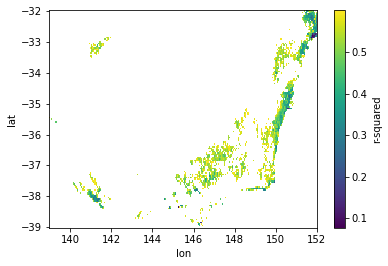

In [15]:
rsq.where(rsq < 0.6).plot()

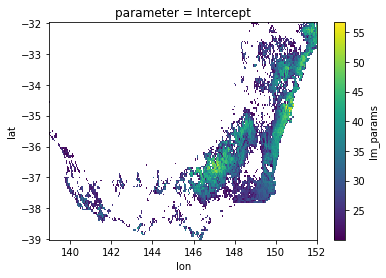

In [31]:
intercept.where(intercept > 20).plot()

In [20]:
print(rsq.sel(lat=-37.5, lon=146.5).values)
print(rsq.sel(lat=-36.5, lon=150).values)
print(rsq.sel(lat=-36.5, lon=147).values)

0.4889620490934874
0.442623974476546
0.6184912142877836


In [32]:
print(intercept.sel(lat=-37.5, lon=146.5).values)
print(intercept.sel(lat=-36.5, lon=150).values)
print(intercept.sel(lat=-36.5, lon=147).values)

33.19495522243612
36.18363270105571
42.95124856795677


In [33]:
print(slope.sel(lat=-37.5, lon=146.5).values)
print(slope.sel(lat=-36.5, lon=150).values)
print(slope.sel(lat=-36.5, lon=147).values)

0.3198256505474334
0.32574129223187026
0.3952027912030217


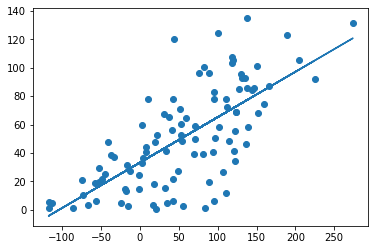

In [48]:
latSel = -37.5
lonSel = 146.5

outdir = 'figures/drought_events/'
out_file = 'example_point3.png'

sm_diff_pt = da_sm_diff.sel(lat = latSel, lon = lonSel)
dryInd_pt = da_dryInd.sel(lat = latSel, lon = lonSel)
PmEQ_pt = da_PmEQ.sel(lat = latSel, lon = lonSel)
intercept_pt = intercept.sel(lat = latSel, lon = lonSel)
slope_pt = slope.sel(lat = latSel, lon = lonSel)

import matplotlib.pyplot as plt
plt.scatter(PmEQ_pt.values[dryInd_pt.values], sm_diff_pt.values[dryInd_pt.values])
sm_pred = intercept_pt.values + (PmEQ_pt.values[dryInd_pt.values]*slope_pt.values)
plt.plot(PmEQ_pt.values[dryInd_pt.values], sm_pred)

plt.savefig(outdir + out_file)

In [46]:
slope_pt
sm_pred = intercept_pt.values + (PmEQ_pt.values[dryInd_pt.values]*slope_pt.values)

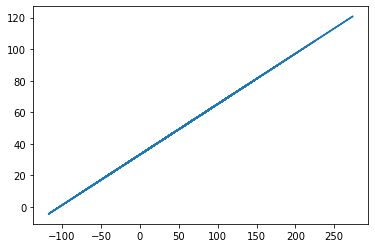

In [41]:
plt.plot(PmEQ_pt.values[dryInd_pt.values], sm_pred)

In [26]:
dryInd_pt.values

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True,  True, False,  True,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True, False, False,  True,
        True, False, False, False,  True,  True, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
        True, False, False,  True, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False,  True, False, False, False,
       False,  True,